# Exploring the availability of Airbnb listings and their characteristics
## How can we promote earlier booking of listings and also discourage hosts from placing listings that are actually not available for rent?

In [260]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

## Load dataset

In [261]:
# Load datasets
source="./airbnb_data/"
calendar=pd.read_csv(source+"calendar.csv")
listings=pd.read_csv(source+"listings.csv")

In [262]:
calendar.head()

,listing_id,date,available,price,metro_area
0,2515,2018-03-05,t,69.0,NYC
1,2515,2018-03-04,t,69.0,NYC
2,2515,2018-03-03,t,69.0,NYC
3,2515,2018-03-02,t,69.0,NYC
4,2515,2018-03-01,t,69.0,NYC


## Clean dataset
### 1) Filter and clean data of interest

In [263]:
print(calendar['metro_area'].unique().tolist())

['NYC', 'denver', 'chicago', 'boston', 'dc']


In [264]:
# Filter only NYC data
calendar = calendar[calendar['metro_area']=='NYC']

# In 'available' column, change true to 1 and false to 0
calendar['available'] = calendar['available'].apply(lambda x:1 if x == 't' else 0)

# Convert date column to data type date
calendar['date'] = pd.to_datetime(calendar['date'])

calendar.head()

,listing_id,date,available,price,metro_area
0,2515,2018-03-05,1,69.0,NYC
1,2515,2018-03-04,1,69.0,NYC
2,2515,2018-03-03,1,69.0,NYC
3,2515,2018-03-02,1,69.0,NYC
4,2515,2018-03-01,1,69.0,NYC


### 2) Create table of available days by month and listing

For each listing, the availability for the next 365 calendar days are stored in the calendar dataset. Availability means that the listing is made available for rental by the host but has not been booked. We also recognise that there is may be an insignificant number of hosts who may have made the listing available for rental but are not actually accepting bookings due to various reasons. Non-availability could mean that the listing has already been booked or it was not made available for rental by the host. 

In [265]:
# Find start_date for dataset of each listing
# start_date = calendar.groupby('listing_id')['date'].min().to_frame()
# start_date = start_date.reset_index()
# start_date.head()

# We can check that all the start dates are in May 2017
# np.mean(start_date['date'].dt.month)

In [266]:
# Sum total number of days in a month with data and number of days which listing is available for
availability = calendar.groupby([pd.Grouper(key='date',freq='M'),'listing_id'])['available'].agg(['sum','count']).reset_index()
availability['not_available_days'] = availability['count'] - availability['sum']
availability = availability.rename({'sum':'available_days','count':'total_days'}, axis=1)
availability.head()

,date,listing_id,available_days,total_days,not_available_days
0,2017-05-31,2515,5,30,25
1,2017-05-31,2595,30,30,0
2,2017-05-31,3647,30,30,0
3,2017-05-31,3831,0,30,30
4,2017-05-31,4611,4,30,26


In [267]:
len(availability)

529789

### 3) Focus on listings & months with low booking rate
We find that a significant percentage of listings and months are available for almost a full month. That is, the listings are shown as available on the calendar on Airbnb but are not booked at all/have extremely low booking rates. We choose to focus on examining why by exploring their characteristics and identifying patterns.

In [268]:
# Number of unique listing ids in dataset
print("Number of unique listings: {}".format(len(availability['listing_id'].unique().tolist())))

# Percentage of listing months which have 0 booking days
print("% of listing-months with zero bookings: {}".format(len(availability[availability['not_available_days'] == 0])/len(availability)*100))

# Create dataset of high-availability months and listings
no_booking = availability[availability['not_available_days']==0]
print("Ave # months/listing with zero bookings: {}".format(len(no_booking)/len(no_booking['listing_id'].unique().tolist())))

Number of unique listings: 40753
% of listing-months with zero bookings: 29.887936518123254
Ave # months/listing with zero bookings: 6.929368517789156


In [269]:
no_booking.head()

,date,listing_id,available_days,total_days,not_available_days
1,2017-05-31,2595,30,30,0
2,2017-05-31,3647,30,30,0
7,2017-05-31,5121,30,30,0
47,2017-05-31,11943,29,29,0
51,2017-05-31,12303,29,29,0


In [270]:
len(no_booking['listing_id'].unique().tolist())

22851

### 4) Create dataset with unique listings and adjustment factor
Since the data ends sometime in May 2018, the count of frequency based on booked_days = 0 may result in an additional month being counted. We calculate an adjustment factor, which is 1 if a month needs to be deducted from the frequency, and 0 if no deduction needs to be made. The adjustment factor is 1 when booked_days = 0 in BOTH May 2017 and May 2018.  
*The count of available days done in the previous step was done by calendar month, not by 30/31 days from the start date of each listing's data. 

In [271]:
may_data = no_booking[no_booking['date'].dt.month == 5]
may_data = may_data.groupby('listing_id')['not_available_days'].sum().reset_index()
may_data.head()

,listing_id,not_available_days
0,2515,0
1,2595,0
2,3647,0
3,3831,0
4,4611,0


In [272]:
adjustment = pd.DataFrame(no_booking['listing_id'].unique())
adjustment = adjustment.rename({0:'listing_id'},axis=1)
adjustment['factor'] = may_data['not_available_days'].apply(lambda x:1 if x==0 else 0)
adjustment['factor'] = adjustment['factor'].fillna(0)
adjustment.shape

(22851, 2)

### 5) Create dataset of unique listings with count of full-availability months
Reminder: full-availability here refers to the entire calendar month being marked as available

In [273]:
print(len(no_booking))
print(len(no_booking['listing_id'].unique().tolist()))

158343
22851


In [274]:
# Listings with zero-booking months (non-unique listings)
no_booking_mth = no_booking.drop(['available_days','not_available_days','total_days','date'], axis=1)
no_booking_mth.head()

,listing_id
1,2595
2,3647
7,5121
47,11943
51,12303


In [275]:
# Add column of frequency i.e. number of zero-booking months per unique listing
no_booking_mth = no_booking_mth['listing_id'].value_counts().reset_index(name='no_months').rename(columns={'index': 'listing_id'})

# Merge no_booking_mth with adjustment
no_booking_mth = no_booking_mth.merge(adjustment, on='listing_id', how='inner')

# Calculate actual number of months and remove adjustment row
no_booking_mth['no_months'] = no_booking_mth['no_months']-no_booking_mth['factor']
no_booking_mth = no_booking_mth.drop('factor',axis=1)
no_booking_mth.no_months = no_booking_mth.no_months.astype(int)

In [276]:
no_booking_mth.head()

,listing_id,no_months
0,40453,12
1,7208745,12
2,17726161,12
3,6904576,12
4,238119,12


In [277]:
# Check that number of unique listings matches that in low_occ table
print(len(no_booking_mth))

22851


We plot a histogram of the full-availability months and see that a significant number of unique listings have a full year of full-availability months. There could be various reasons why these listings are experiencing a full year of zero bookings. Possible reasons:  
1) The quality of the listing could be poor such that no one books them, in which case we can explore reasons for this and characterise such listings to make recommendations to hosts.  
2) The listings are outdated and no longer maintained by hosts, in which case it would be helpful to remove them fromt he website so that potential customers do not have to sift through unnecessarily large numbers of listings. Nonetheless, we believe this forms a relatively smaller proportion of all listings.  
3) Related to point 2, the hosts are currently staying in their listing and indicate the listing as being available even though it is not. They reject requests to rent. It would be helpful to motivate hosts to update accurate availabilities to enhance customer experience and efficiency of matching customers to listings. Again, we believe this group forms a relatively smaller proportion of all listings.

Text(0, 0.5, 'Count of listings')

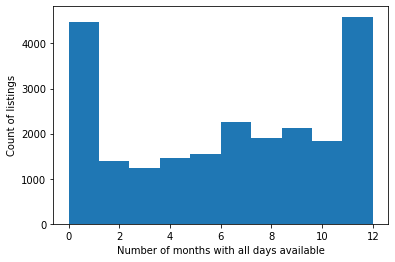

In [288]:
plt.hist(no_booking_mth['no_months'])
plt.xlabel('Number of months with all days available')
plt.ylabel('Count of listings')

In [279]:
# Export dataset of listings and number of zero-booking months
#no_booking_mth.to_csv(r'no_booking_listings.csv', index=False)

## Merge datasets
### 1) Merge listings and no_booking_mth to characterise the listings with 0 and 12 full-availability months

In [304]:
listings.head()

,accommodates,amenities,availability_30,bathrooms,bed_type,bedrooms,beds,cancellation_policy,city,has_availability,...,review_scores_checkin,review_scores_cleanliness,review_scores_communication,review_scores_location,review_scores_rating,review_scores_value,room_type,state,weekly_price,zipcode
0,2.0,"{""Cable TV"",""Wireless Internet"",""Air condition...",24,1.0,Real Bed,1.0,1.0,moderate,sunnysidebronx,NaN,...,10.0,10.0,10.0,10.0,100.0,10.0,Private room,NY,NaN,10464
1,4.0,"{TV,Internet,""Wireless Internet"",""Air conditio...",30,1.0,Real Bed,1.0,1.0,flexible,sunnysidebronx,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Private room,NY,NaN,10464
2,4.0,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",30,3.0,Real Bed,3.0,3.0,strict,sunnysidebronx,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Entire home/apt,NY,NaN,10464
3,3.0,"{TV,Internet,""Wireless Internet"",""Air conditio...",8,1.0,Real Bed,1.0,1.0,strict,long island city,NaN,...,10.0,10.0,10.0,10.0,93.0,10.0,Entire home/apt,NY,775.0,10464
4,4.0,"{Internet,""Wireless Internet"",""Air conditionin...",17,1.0,Real Bed,1.0,1.0,moderate,sunnysidebronx,NaN,...,10.0,10.0,10.0,10.0,97.0,10.0,Private room,NY,350.0,10464


In [305]:
print(listings.columns)

Index(['accommodates', 'amenities', 'availability_30', 'bathrooms', 'bed_type',
       'bedrooms', 'beds', 'cancellation_policy', 'city', 'has_availability',
       'host_id', 'id', 'instant_bookable', 'latitude', 'longitude',
       'metropolitan', 'name', 'price', 'property_type',
       'review_scores_checkin', 'review_scores_cleanliness',
       'review_scores_communication', 'review_scores_location',
       'review_scores_rating', 'review_scores_value', 'room_type', 'state',
       'weekly_price', 'zipcode'],
      dtype='object')


In [306]:
# Filter only listings in New York
listings_new = listings[listings['state']=='NY'] 

# Drop unnecessary columns
listings_new = listings_new.drop(['has_availability','availability_30','name','weekly_price','state'],axis=1)

In [307]:
listings_new.shape

(40738, 24)

In [308]:
no_booking_list = no_booking_mth.merge(listings_new, left_on='listing_id', right_on='id', how='inner')
no_booking_list = no_booking_list.drop(['id'], axis=1)

In [309]:
no_booking_list.head()

,listing_id,no_months,accommodates,amenities,bathrooms,bed_type,bedrooms,beds,cancellation_policy,city,...,price,property_type,review_scores_checkin,review_scores_cleanliness,review_scores_communication,review_scores_location,review_scores_rating,review_scores_value,room_type,zipcode
0,40453,12,1.0,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",1.0,Real Bed,1.0,1.0,flexible,new york,...,250.0,Apartment,10.0,9.0,10.0,10.0,100.0,10.0,Entire home/apt,10065
1,7208745,12,2.0,"{TV,""Cable TV"",""Wireless Internet"",""Air condit...",1.5,Real Bed,1.0,1.0,strict,queens,...,60.0,House,NaN,NaN,NaN,NaN,100.0,NaN,Private room,11365.0
2,17726161,12,2.0,"{TV,""Cable TV"",""Wireless Internet"",""Free parki...",1.0,Real Bed,2.0,2.0,flexible,jamaica,...,85.0,House,NaN,NaN,NaN,NaN,NaN,NaN,Private room,11434.0
3,6904576,12,1.0,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",1.0,Real Bed,1.0,1.0,strict,new york,...,55.0,Apartment,9.0,9.0,9.0,9.0,90.0,9.0,Private room,10031.0
4,238119,12,2.0,"{TV,Internet,""Wireless Internet"",""Air conditio...",2.0,Real Bed,1.0,1.0,strict,brooklyn,...,135.0,House,10.0,10.0,10.0,9.0,100.0,9.0,Private room,11230


In [310]:
for i in range(13):
    print("Month {}: {}".format(i,len(no_booking_list[no_booking_list['no_months']==i])))
    print(len(no_booking_list[no_booking_list['no_months']==i])/len(no_booking_list)*100)

Month 0: 1839
8.052721460787318
Month 1: 2645
11.582081709506504
Month 2: 1390
6.08661382843631
Month 3: 1231
5.390375268205106
Month 4: 1469
6.432543679117223
Month 5: 1554
6.8047466830144065
Month 6: 1086
4.755440732145203
Month 7: 1178
5.158295748128038
Month 8: 1905
8.341726146166309
Month 9: 2125
9.30507509742961
Month 10: 1827
8.000175154354777
Month 11: 3054
13.373034987082367
Month 12: 1534
6.717169505626834


In [311]:
# Export merged dataset
#no_booking_list.to_csv(r'full_mth_avail_listings.csv', index=False)

### 2) Merge mth_full_availability (from no_booking) with listings to understand characteristics of remaining supply for each month 

In [312]:
no_booking.head()

,date,listing_id,available_days,total_days,not_available_days
1,2017-05-31,2595,30,30,0
2,2017-05-31,3647,30,30,0
7,2017-05-31,5121,30,30,0
47,2017-05-31,11943,29,29,0
51,2017-05-31,12303,29,29,0


In [313]:
mth_full_availability = no_booking.drop(['available_days','total_days','not_available_days'], axis=1)
mth_full_availability.head()

,date,listing_id
1,2017-05-31,2595
2,2017-05-31,3647
7,2017-05-31,5121
47,2017-05-31,11943
51,2017-05-31,12303


In [314]:
mthly_availability = mth_full_availability.merge(listings_new, left_on='listing_id', right_on='id', how='inner')
mthly_availability = mthly_availability.drop(['id'], axis=1)
mthly_availability.head()

,date,listing_id,accommodates,amenities,bathrooms,bed_type,bedrooms,beds,cancellation_policy,city,...,price,property_type,review_scores_checkin,review_scores_cleanliness,review_scores_communication,review_scores_location,review_scores_rating,review_scores_value,room_type,zipcode
0,2017-05-31,2595,2.0,"{TV,Internet,""Wireless Internet"",""Air conditio...",1.0,Real Bed,0.0,1.0,strict,new york,...,225.0,Apartment,9.0,9.0,9.0,10.0,97.0,9.0,Entire home/apt,10018
1,2017-06-30,2595,2.0,"{TV,Internet,""Wireless Internet"",""Air conditio...",1.0,Real Bed,0.0,1.0,strict,new york,...,225.0,Apartment,9.0,9.0,9.0,10.0,97.0,9.0,Entire home/apt,10018
2,2017-07-31,2595,2.0,"{TV,Internet,""Wireless Internet"",""Air conditio...",1.0,Real Bed,0.0,1.0,strict,new york,...,225.0,Apartment,9.0,9.0,9.0,10.0,97.0,9.0,Entire home/apt,10018
3,2017-08-31,2595,2.0,"{TV,Internet,""Wireless Internet"",""Air conditio...",1.0,Real Bed,0.0,1.0,strict,new york,...,225.0,Apartment,9.0,9.0,9.0,10.0,97.0,9.0,Entire home/apt,10018
4,2017-09-30,2595,2.0,"{TV,Internet,""Wireless Internet"",""Air conditio...",1.0,Real Bed,0.0,1.0,strict,new york,...,225.0,Apartment,9.0,9.0,9.0,10.0,97.0,9.0,Entire home/apt,10018


In [315]:
# Export merged dataset
#mthly_availability.to_csv(r'mthly_availability.csv', index=False)

## Correlate high-availability with features

The number of high-availability months is not highly correlated to any particular feature of the listing, as shown below.

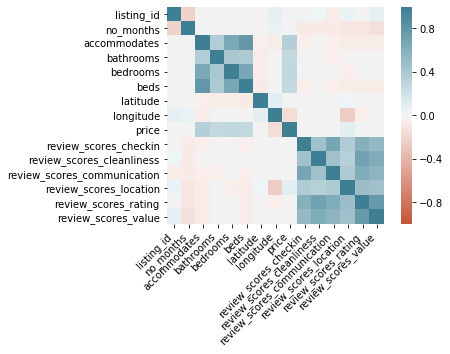

In [286]:
corr = no_booking_list.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);